<a href="https://colab.research.google.com/github/p73rl11zq/CV_base/blob/main/IU_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import cv2
import random

In [ ]:
img1 = cv2.imread('pictures1/1.jpg')
img_gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)

img2 = cv2.imread('pictures1/2.jpg')
img_gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

img3 = cv2.imread('pictures1/3.jpg')
img_gray3 = cv2.cvtColor(img3, cv2.COLOR_BGR2GRAY)

img4 = cv2.imread('pictures1/4.jpg')
img_gray4 = cv2.cvtColor(img4, cv2.COLOR_BGR2GRAY)

img5 = cv2.imread('pictures1/5.jpg')
img_gray5 = cv2.cvtColor(img5, cv2.COLOR_BGR2GRAY)

img6 = cv2.imread('pictures1/6.jpg')
img_gray6 = cv2.cvtColor(img6, cv2.COLOR_BGR2GRAY)

img7 = cv2.imread('pictures1/7.jpg')
img_gray7 = cv2.cvtColor(img7, cv2.COLOR_BGR2GRAY)

img8 = cv2.imread('pictures1/8.jpg')
img_gray8 = cv2.cvtColor(img8, cv2.COLOR_BGR2GRAY)

img_list = [img1, img2, img3, img4, img5, img6, img7, img8]
img_gray_list = [img_gray1, img_gray2, img_gray3, img_gray4, img_gray5, img_gray6, img_gray7, img_gray8]

# 1) Searching for corners

In [ ]:
def mesivo(image, slider, flag):
    
    redundant = int((windowSize - 1) / 2)
    result = np.zeros((image.shape))
    corner = dict()
    
    for i in range(redundant, image.shape[0] - redundant):
        for j in range(redundant, image.shape[1] - redundant):
            
            if flag=='convolution':
                result[i,j] = np.sum(image[i-redundant:i+redundant+1, j-redundant:j+redundant+1] * slider)
                
            elif flag=='extremum_max':
                x = image[i-redundant:i+redundant+1, j-redundant:j+redundant+1]
                if (image[i][j] == np.max(x)):
                    corner[image[i][j]] = [j,i]
                    
    if flag=='convolution': 
        return result
    
    elif flag=='extremum_max':
        return corner
    

def corner_detect(image_gray, corners_num, windowSize):
    
    corners = []
    slider = np.ones(([windowSize, windowSize]))
    k = 0.04 # {0.04:0.06}
    
    gauss_img = cv2.GaussianBlur(image_gray, (5,5), 3)
    R = np.zeros((gauss_img.shape))
    
    dy, dx = np.gradient(gauss_img) # x&y-axis gradient calculating 
    g_xx = mesivo(dx*dx, slider, 'convolution') # 1st element  
    g_yy = mesivo(dy*dy, slider, 'convolution') # 4th element 
    g_xy = mesivo(dx*dy, slider, 'convolution') # 2&3rd elements  
    
    for i in range(gauss_img.shape[0]):
        for j in range(gauss_img.shape[1]):
            
            M = np.array([[g_xx[i][j], g_xy[i][j]], [g_xy[i][j], g_yy[i][j]]])
            detM = np.linalg.det(M)
            trM = g_xx[i][j] + g_yy[i][j]
            R[i][j] = detM - k * (trM)**2
            
    corner = mesivo(R, slider, 'extremum_max')
    
    for key in sorted(corner.keys(), reverse=True): 
        corners.append(corner[key])
        
    return np.array(corners[0:corners_num])

In [ ]:
%%time
windowSize = 9 
cornenrs_num = 10 
corners_list = []

for i in range(len(img_gray_list)):
    corners = corner_detect(img_gray_list[i], cornenrs_num, windowSize)
    corners_list.append(corners)

Wall time: 9min 3s


### 1.1) Plotting

In [ ]:
def mapping(imageList, rows, cols, size, corners):

    grid_image = gridspec.GridSpec(rows, cols)
    grid_image.update(wspace=0.0, hspace=0.1)
    
    plt.figure(figsize=(size))
    
    for i in range(len(imageList)):
        
        ax = plt.subplot(grid_image[i])
        
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        
        inner_img = imageList[i].copy()
        inner_img = cv2.cvtColor(inner_img, cv2.COLOR_BGR2RGB)
        
        ax.scatter(corners[i][:, 0], corners[i][:, 1], s=25, edgecolors='blue', facecolors='red')
        
        plt.subplot(rows, cols, i+1)
        
        if len(inner_img.shape) < 3:
            plt.imshow(inner_img, plt.cm.gray)
        else:
            plt.imshow(inner_img)
            
        if i<(len(imageList)-1):
            plt.title(str(i+5) + '-->')     
        else:
            plt.title(str(i+5))
        
        plt.axis('off')
        
    plt.show()

Imaging:

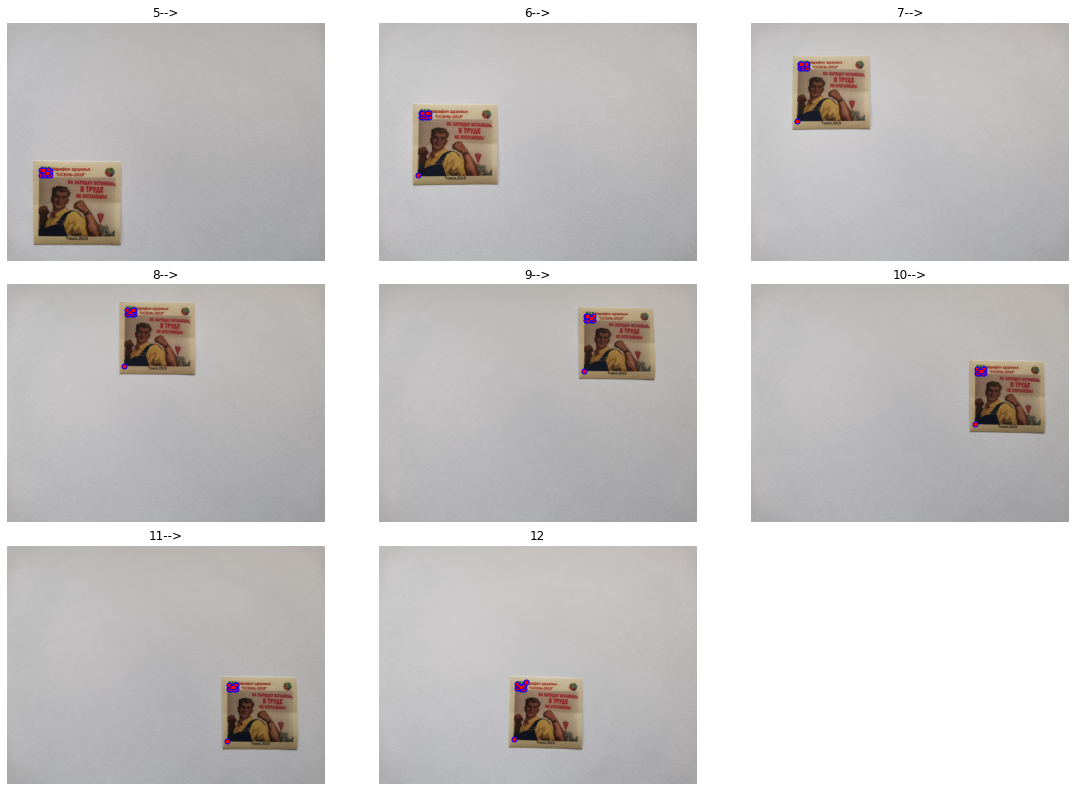

In [ ]:
mapping(img_list, 3, 3, (20, 14), corners_list)

# 2) Checking the corners matching

In [ ]:
def k_corr_search(img1, img2, c1, c2, R):
    
    sum1, sum2, sum_main = 0, 0, 0
    mean_temp1, mean_temp2 = [], []

    for i in range(-R, R+1):
        for j in range(-R, R+1):
            mean_temp1.append(img1[c1[1]+i][c1[0]+j])
            mean_temp2.append(img2[c2[1]+i][c2[0]+j])
            
    mean_desc1 = np.mean(mean_temp1)
    mean_desc2 = np.mean(mean_temp2)
    
    for i in range(-R, R+1):
        for j in range(-R, R+1):
            sum_main += (img1[c1[1]+i][c1[0]+j] - mean_desc1) * (img2[c2[1]+i][c2[0]+j] - mean_desc2)
            
    for i in range(-R, R+1):
        for j in range(-R, R+1):
            sum1 += (img1[c1[1]+i][c1[0]+j] - mean_desc1)**2
            sum2 += (img2[c2[1]+i][c2[0]+j] - mean_desc2)**2
    
    sum_down = np.sqrt(sum1 * sum2)
   
    k_corr = sum_main/sum_down
    
    return k_corr


def corr_match(img1, img2, corners1, corners2, R, treshold):
    
    matching = []
    ncc = np.zeros([corners1.shape[0], corners2.shape[0]])
    
    for i in range(corners1.shape[0]):
        for j in range(corners2.shape[0]):
            
            ncc[i][j] = k_corr_search(img1, img2, corners1[i], corners2[j], R)
            
            if ncc[i][j] > treshold:
                matching.append((corners1[i], corners2[j]))
                
    return matching

Plotting two closest matching:

In [ ]:
R = 9
treshold = 0.968
matching_list = []

for i in range(len(img_gray_list)-1):
    matching = corr_match(img_gray_list[i], img_gray_list[i+1], corners_list[i], corners_list[i+1], R, treshold)
    matching_list.append(matching)

In [ ]:
def trackercatcher(img1, img2, size, matching):
    
    fig = plt.figure(figsize=(size))
    
    img1g = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    img2g = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
    
    plt.imshow(np.hstack((img1g, img2g)))
    
    for p1, p2 in matching:
        
        plt.scatter(p1[0], p1[1], s=35, edgecolors='r', facecolors='r')
        plt.scatter(p2[0] + img1.shape[1], p2[1], s=35, edgecolors='r', facecolors='r')
        plt.plot([p1[0], p2[0] + img1.shape[1]], [p1[1], p2[1]])
        
    #plt.axis('off')
    plt.show()

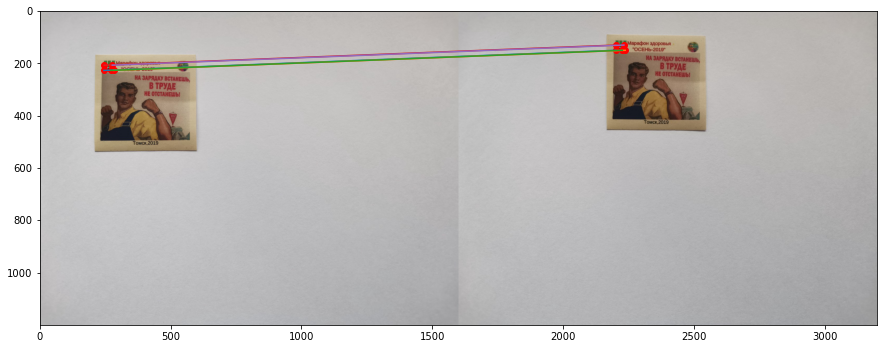

In [ ]:
# trackercatcher(img_list[1], img_list[2], (15,15), matching_list[1])
num = 2
trackercatcher(img_list[num], img_list[num+1], (15,15), matching_list[num])

# 3) Mapping of motion trajectory

In [ ]:
def show_trajectory(matchings_list):
    
    cx_list, cy_list = [], []
    track_img = np.zeros((img1.shape))

    for i in range(len(matchings_list)):
    
        matching = matchings_list[i]
        cx_list.append((int(matching[0][0][0]), int(matching[0][0][1])))
        cy_list.append((int(matching[0][1][0]), int(matching[0][1][1])))
        track_img = cv2.arrowedLine(track_img, cx_list[i], cy_list[i], (255,0,0), 6)
    
    plt.imshow(track_img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


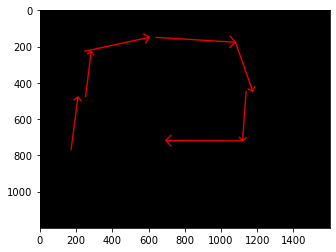

In [ ]:
show_trajectory(matching_list)